# Simulación de curvas periódicas

In [15]:
%load_ext autoreload
%autoreload 2

import os
import sys

import numpy as np
import pandas as pd
from scipy import signal

import torch

import matplotlib.pyplot as plt

from torch.utils.data import Dataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generación de curvas períodicas

### Visualización de curvas

In [16]:
def plot_periodic(mjd, mag, P, ax):
    ax[0].plot(mjd, mag, '.')
    ax[0].set_xlabel('Tiempo')
    ax[1].plot(np.mod(mjd, P)/P, mag, '.')
    ax[1].set_xlabel('Fase');

### Señal cuadrada

In [17]:
def random_periodic_square_signal(period, seq_len=100, s_noise=0.2, irregular=True):
    """Genera una curva aleatoria de señales cuadradas.

    Parameters
    ----------
    seq_len : int
        Número int que define la cantidad de períodos a generar.
    s_noise : float
        float que fija la cantidad de ruido a agregar.

    Returns
    -------
    tuple
        tuple con los tiempos y magnitudes de la curva.            
    """    
    mjd = np.linspace(0, 4, num=seq_len, dtype=np.float32)
    if irregular:
        mjd += np.random.randn(seq_len)*0.1
    mjd = np.sort(mjd)
    mag = signal.square(2 * np.pi * mjd/period) 
    mag += np.random.randn(seq_len)*s_noise
    return mjd, mag

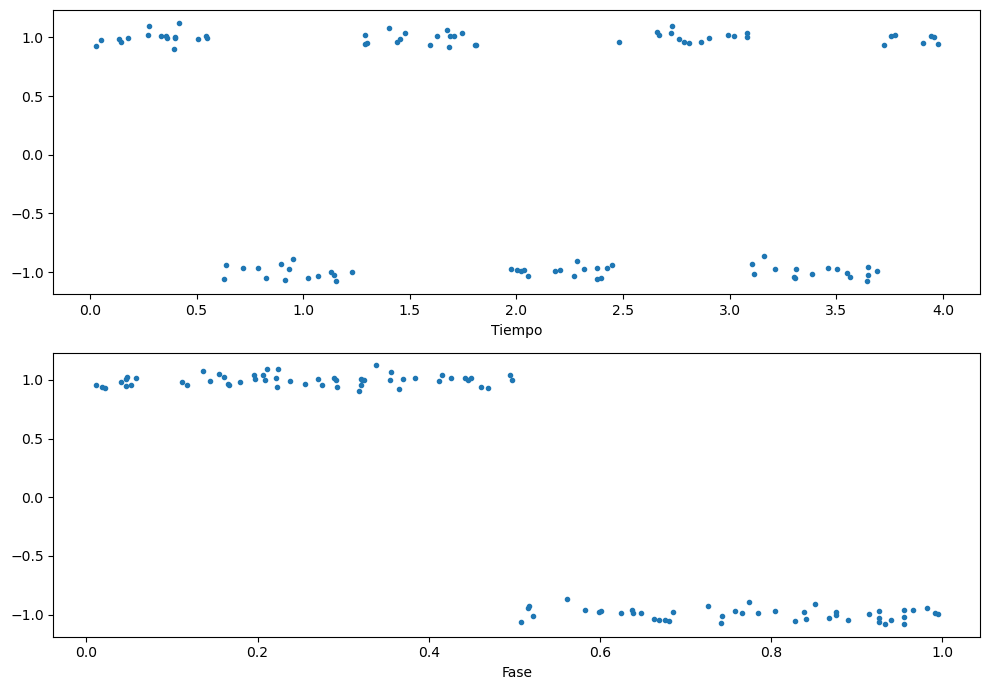

In [18]:
P = 1.234
mjd, mag = random_periodic_square_signal(P, s_noise=0.05)

fig, ax = plt.subplots(2, figsize=(10,7), tight_layout=True)
plot_periodic(mjd, mag, P, ax)

## Señal diente de sierra

In [19]:
def random_periodic_sawtooth_signal(period, seq_len=100, s_noise=0.2, irregular=True):
    """Genera una curva aleatoria de diente de sierra.

    Parameters
    ----------
    seq_len : int
        Número int que define la cantidad de períodos a generar.
    s_noise : float
        float que fija la cantidad de ruido a agregar.

    Returns
    -------
    tuple
        tuple con los tiempos y magnitudes de la curva.            
    """    
    mjd = np.linspace(0, 4, num=seq_len, dtype=np.float32)
    if irregular:
        mjd += np.random.randn(seq_len)*0.1
    mjd = np.sort(mjd)
    mag = signal.sawtooth(2 * np.pi * mjd/period) 
    mag += np.random.randn(seq_len)*s_noise
    return mjd, mag

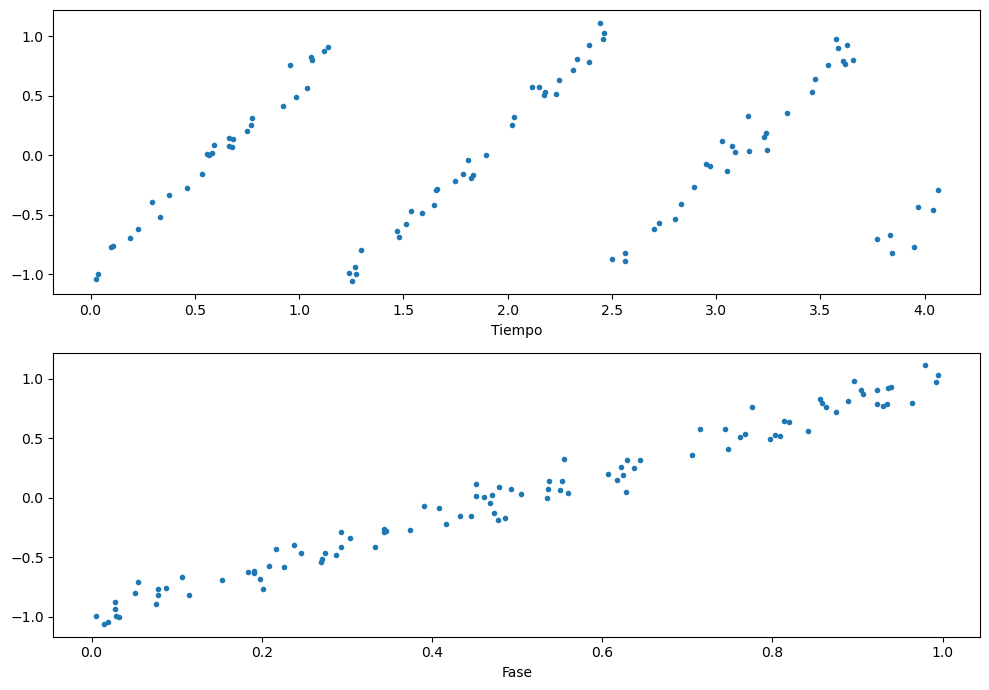

In [20]:
P = 1.234
mjd, mag = random_periodic_sawtooth_signal(P, s_noise=0.1)

fig, ax = plt.subplots(2, figsize=(10,7), tight_layout=True)
plot_periodic(mjd, mag, P, ax)

## Suma de sinusoides

In [21]:
def random_periodic_sin_mix(period, seq_len=100, s_noise=0.2, irregular=True):
    """Genera una curva aleatoria de suma de sinusoides.

    Parameters
    ----------
    seq_len : int
        Número int que define la cantidad de períodos a generar.
    s_noise : float
        float que fija la cantidad de ruido a agregar.

    Returns
    -------
    tuple
        tuple con los tiempos y magnitudes de la curva.            
    """
    mjd = np.linspace(0, 4, num=seq_len, dtype=np.float32)
    if irregular:
        mjd += np.random.randn(seq_len)*0.1
    mjd = np.sort(mjd)
    mag = np.sin(2.0*np.pi*mjd/period) + 0.5*np.sin(2.0*np.pi*2*mjd/period)  + 0.25*np.sin(2.0*np.pi*3*mjd/period)
    mag += np.random.randn(seq_len)*s_noise
    return mjd, mag

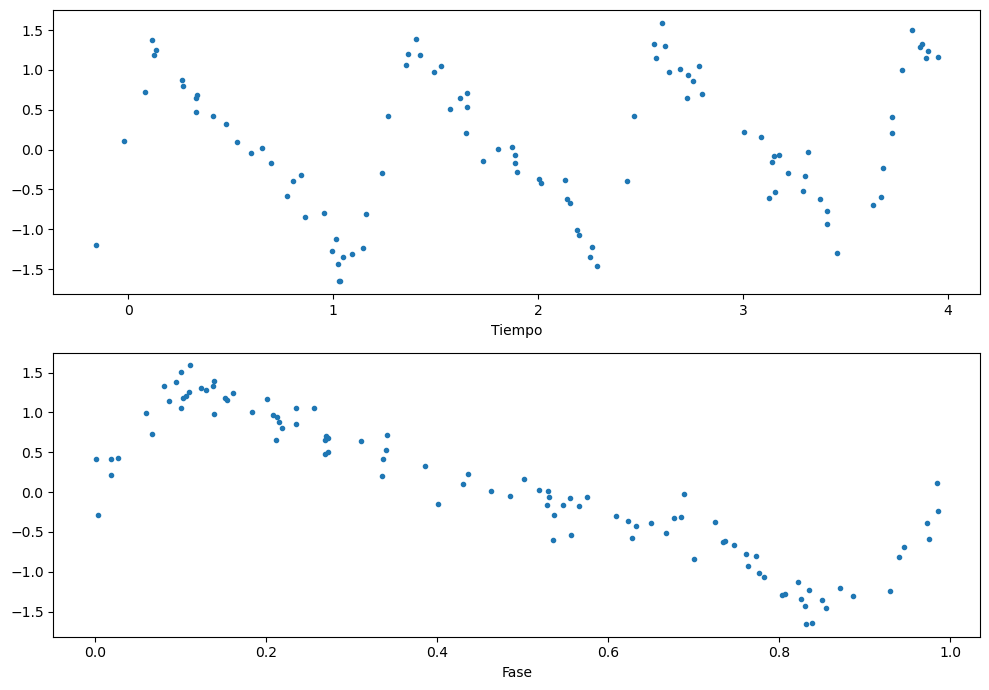

In [22]:
P = 1.234
mjd, mag = random_periodic_sin_mix(P)

fig, ax = plt.subplots(2, figsize=(10,7), tight_layout=True)
plot_periodic(mjd, mag, P, ax)

## Adaptación a dataset de Pytorch

### Dataset class

In [23]:
class lc_dataset(Dataset):
    def __init__(self, seed=42):
        # Set seed
        self.seed = seed
        np.random.seed(self.seed)

        # Generators
        self.curve_generators = {'square': random_periodic_square_signal,
                                'sawtooth': random_periodic_sawtooth_signal,
                                'sinmix': random_periodic_sin_mix}

        # Curve data
        self.period_list = []
        self.mjd_list = []
        self.mag_list = []
        self.labels = []

    def generate_periods(self, N, min_period, max_period):
        """Genera una lista de períodos random.

        Parameters
        ----------
        N : int
            Número int que define la cantidad de períodos a generar.
        min_period : float
            float que define el mínimo valor posible a generar.
        max_period : float
            float que define el máximo valor posible a generar.

        Returns
        -------
        np.ndarray
            np.ndarray con el arreglo de períodos generados.            
        """
        random_period_list = []
        for idx in range(N):
            random_period = np.random.uniform(min_period, max_period)
            random_period_list.append(random_period)
        return random_period_list
        
    def add_curves(self, curve_type, N, seq_len, min_period, max_period, label):
        """Añade N curvas de un determinado tipo al dataset.

        Parameters
        ----------
        curve_type : str
            str que define el tipo de curvas a generar.
        N : int
            Número int que define la cantidad de períodos a generar.            
        min_period : float
            float que define el mínimo valor posible a generar.
        max_period : float
            float que define el máximo valor posible a generar.
        label : int
            int que define el label que tendrán las curvas generadas.            
        """
        period_list = self.generate_periods(N, min_period, max_period)
        self.period_list += period_list
        for period in period_list:
            mjd, mag = self.curve_generators[curve_type](period, seq_len=seq_len)
            self.mjd_list.append(mjd)
            self.mag_list.append(mag)
            self.labels.append(label)

    def to_df(self):
        """Transforma los datos generados en un Pandas DataFrame.

        Returns
        -------
        pd.DataFrame
            pd.DataFrame con los datos generados.            
        """        
        dataset_df = pd.DataFrame({'mjd':self.mjd_list,
                                    'mag':self.mag_list,
                                    'period':self.period_list,
                                    'label':self.labels})
        return dataset_df

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        curve_dict = {'mjd':torch.tensor(self.mjd_list[idx]),
                    'mag':torch.tensor(self.mag_list[idx]),
                    'period':torch.tensor(self.period_list[idx]),
                    'label':torch.tensor(self.labels[idx])}
        return curve_dict

### Prueba

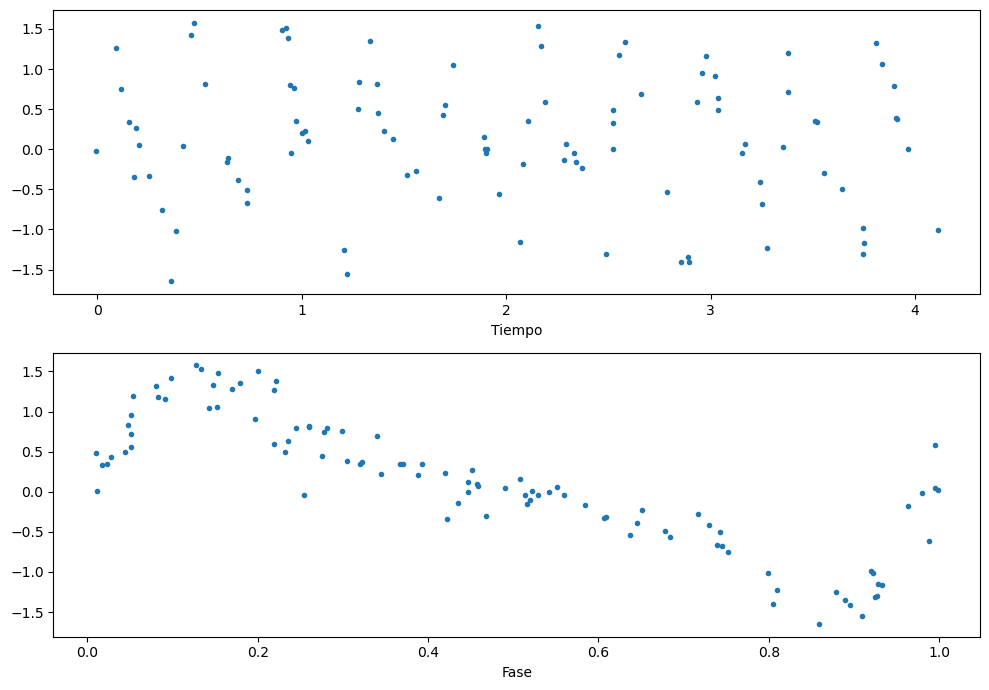

In [24]:
dataset = lc_dataset()
dataset.add_curves('sinmix', 100, 100, 0.2, 2, 0)

fig, ax = plt.subplots(2, figsize=(10,7), tight_layout=True)
obj_id = 40
plot_periodic(*dataset.to_df().loc[obj_id].values[:-1], ax)

In [26]:
dataset.add_curves('sawtooth', 100, 100,5, 10, 1)
dataset.to_df()

,mjd,mag,period,label
0,"[-0.07754476, 0.008704707, 0.010503305, 0.0899...","[-1.2239591, 0.46228376, 0.1538344, 1.8606755,...",0.874172,0
1,"[-0.019617647, 0.01990597, 0.08268076, 0.08778...","[-0.0023624094, 0.21607804, 1.1470501, 0.58618...",1.911286,0
2,"[0.057655696, 0.07152905, 0.081779614, 0.10646...","[0.67743087, 0.9191666, 0.5622052, 1.283612, 1...",1.517589,0
3,"[-0.11105759, 0.08911502, 0.17437592, 0.189972...","[-1.3581426, 1.0009868, 1.3708396, 1.4893783, ...",1.277585,0
4,"[-0.05176113, 0.06278284, 0.079165794, 0.14893...","[-1.4287921, 0.90269285, 0.9915818, 0.6338268,...",0.480834,0
...,...,...,...,...
195,"[-0.06037448, -0.021978624, 0.080224425, 0.214...","[1.134834548725925, 0.8083569393507781, -1.136...",8.676480,1
196,"[-0.026268579, 0.05686235, 0.07704073, 0.09226...","[0.8285063738997064, -1.0597885820073645, -1.1...",8.017504,1
197,"[-0.11325406, -0.0041802935, 0.11295654, 0.115...","[1.1842771276361852, 1.2439456637078774, -0.45...",8.268147,1
198,"[0.042412084, 0.057044663, 0.06735375, 0.07047...","[-1.0871041407570774, -0.962327988055821, -0.8...",6.052919,1
